In [50]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
train=pd.read_csv('./Data/Train.csv')
test=pd.read_csv('./Data/Test.csv')
train['seperate']=0
test['seperate']=1
data=pd.concat([train,test])

In [60]:
train.shape,test.shape

((1460, 82), (1459, 81))

In [61]:
data.isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            2721
BedroomAbvGr        0
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LowQualFinSF        0
MSSubClass          0
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2814
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive          0
PoolArea            0
PoolQC    

In [62]:
data_without_null=data.dropna()
data_without_null.shape[0],data.shape[0]
#seems like every column has some kind of missing value. 

(0, 2919)

# check Target Attribute : SalePrice<br>
# we will use histogram to check the attribute is follow normal distribution. 

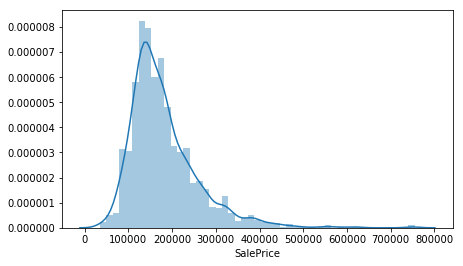

In [63]:
plt.figure(figsize=(7,4))
sns.distplot(data['SalePrice'].dropna());

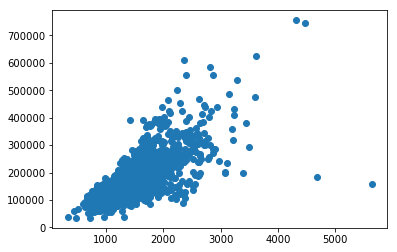

In [64]:
#The histogram is left skewed. So we will use log 1p to remove the skewness
plt.scatter(train['GrLivArea'],train['SalePrice'])

is all training data usable? start from targeting variable, remove the outliers. large living area but lower than the avearge. Therefore we need to find out those outliers and remove them. 
Using the old trick: check the describe. and index the dataframe based on the describe()

In [65]:
train[ (train['GrLivArea']>3090) & (train['SalePrice']<190000)][['Id','GrLivArea','SalePrice']]

,Id,GrLivArea,SalePrice
523,524,4676,184750
1298,1299,5642,160000


In [66]:
#define the new train dataset
train=train.drop((train['GrLivArea']>3090) & (train['SalePrice']<190000))
#no longer requrie the old index. 
train.reset_index(drop=True, inplace=True)
train['SalePrice']=np.log1p(train['SalePrice'])
y=train['SalePrice'].reset_index(drop=True)

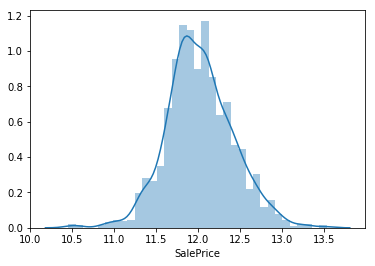

In [69]:
#recheck the histgram
sns.distplot(train['SalePrice']);
# the data is more balaneced. Suitable for training and prediction purpose 

# Features 

# Step1: drop ID and combine all features from train and test together

In [70]:
train.drop(['Id'],axis=1, inplace=True)
test.drop(['Id'],axis=1, inplace=True)

In [75]:
train_features=train.drop(['SalePrice'],axis=1,inplace=True)
test_features=test
features=pd.concat([train_features,test_features]).reset_index(drop=True)

In [81]:
features['MSSubClass'].value_counts()

20     543
60     276
50     143
120     95
30      70
70      68
160     65
80      60
90      57
190     31
85      28
180      7
75       7
45       6
40       2
150      1
Name: MSSubClass, dtype: int64

In [83]:
features['Exterior1st'].mode()[0]

'VinylSd'

In [25]:
# Since the form is right skewed. I decided to use log-transformation:
data['saleprice_log']=np.log(data['SalePrice'])
data[['SalePrice','saleprice_log']].iloc[4:9]

,SalePrice,saleprice_log
4,250000.0,12.429216
5,143000.0,11.870600
6,307000.0,12.634603
7,200000.0,12.206073
8,129900.0,11.774520


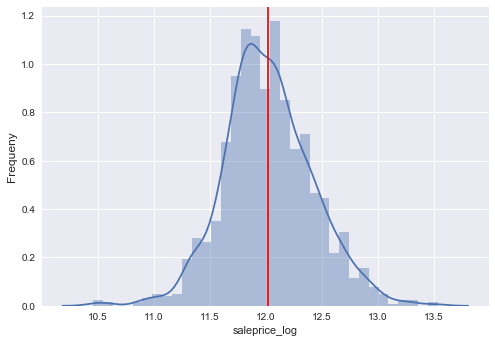

In [26]:
#double check the plot
fig,ax=plt.subplots()
sns.distplot(data['saleprice_log'].dropna());
saleprice_log_mean=np.round(np.mean(data['saleprice_log']),2)
plt.axvline(saleprice_log_mean,color='r');
ax.set_ylabel('Frequeny',fontsize=12);

# Do a ranking on all of the missing values and deal with them from the largest missing feature attributes

In [49]:
# First deal with numerical data
percent_missing=data.select_dtypes(exclude=['object']).isnull().sum()/len(data)
missing_dataframe=pd.DataFrame(percent_missing, columns={'Rank'})
missing_dataframe.sort_values(by='Rank', ascending=False).iloc[0:15]

,Rank
saleprice_log,0.499829
SalePrice,0.499829
LotFrontage,0.166495
GarageYrBlt,0.054471
MasVnrArea,0.007879
BsmtFullBath,0.000685
BsmtHalfBath,0.000685
BsmtFinSF2,0.000343
BsmtUnfSF,0.000343
GarageArea,0.000343


# Calculate the skew for each numerical column and Rrank them <br>
# To check which one has the highest unskewness.

In [54]:
Numeric_index=data.select_dtypes(exclude=['object']).columns

In [74]:
Numeric_index

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
       'YearBuilt', 'YearRemodAdd', 'YrSold', 'seperate', 'saleprice_log'],
      dtype='object')

In [80]:
Numeric_rank={}
for i in Numeric_index:
    Numeric_rank[i]=data[i].skew()

In [86]:
Numeric_Skew_percentage=data.select_dtypes(exclude=['object']).skew().sort_values(ascending=False)

In [87]:
pd.DataFrame(Numeric_Skew_percentage,columns={'Rank_Skew_Percentage'})

,Rank_Skew_Percentage
MiscVal,21.958480
PoolArea,16.907017
LotArea,12.829025
LowQualFinSF,12.094977
3SsnPorch,11.381914
KitchenAbvGr,4.304467
BsmtFinSF2,4.147456
EnclosedPorch,4.005950
ScreenPorch,3.948723
BsmtHalfBath,3.932018


In [ ]:
# if data has zero how to deal with it? 

In [91]:
#drop ID, seperate in the original dataset and start to do box-cox transformation 
new_Numeric,fitted_lambda=stats.boxcox(data.drop(['Id','seperate'],axis=1).select_dtypes(exclude=['object']))

/Users/wenze/anaconda/lib/python3.6/site-packages/scipy/stats/morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


ValueError: Data must be positive.

In [92]:
x_bc, lmda=stats.boxcox(data['MiscVal'])
pd.Series(x_bc).hist()
plt.show()
stats.probplot(x_bc, dist="norm", plot=pylab)
pylab.show()

ValueError: Data must be positive.

In [24]:
col=data.columns.tolist()

In [8]:
data['MSSubClass'].dtype

dtype('int64')

In [9]:
#why this one doens't work?

In [11]:
num_data=data.select_dtypes(exclude=['object'])
cate_data=data.select_dtypes(include=['object'])

In [ ]:
data.head()

In [12]:
num_data.isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
BedroomAbvGr        0
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFullBath        2
BsmtHalfBath        2
BsmtUnfSF           1
EnclosedPorch       0
Fireplaces          0
FullBath            0
GarageArea          1
GarageCars          1
GarageYrBlt       159
GrLivArea           0
HalfBath            0
Id                  0
KitchenAbvGr        0
LotArea             0
LotFrontage       486
LowQualFinSF        0
MSSubClass          0
MasVnrArea         23
MiscVal             0
MoSold              0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PoolArea            0
SalePrice        1459
ScreenPorch         0
TotRmsAbvGrd        0
TotalBsmtSF         1
WoodDeckSF          0
YearBuilt           0
YearRemodAdd        0
YrSold              0
seperate            0
dtype: int64

In [13]:
#GarageArea

In [14]:
data['GarageArea'].value_counts()

0.0       157
576.0      97
440.0      96
240.0      69
484.0      68
528.0      65
400.0      58
480.0      54
264.0      51
288.0      50
308.0      48
280.0      30
336.0      29
420.0      29
672.0      23
216.0      23
462.0      23
506.0      21
384.0      21
504.0      21
286.0      20
312.0      19
550.0      17
624.0      17
495.0      17
352.0      17
525.0      17
360.0      16
180.0      16
564.0      16
         ... 
958.0       1
808.0       1
363.0       1
752.0       1
954.0       1
284.0       1
209.0       1
604.0       1
892.0       1
413.0       1
258.0       1
1041.0      1
639.0       1
859.0       1
741.0       1
535.0       1
609.0       1
1184.0      1
853.0       1
1110.0      1
713.0       1
611.0       1
963.0       1
186.0       1
265.0       1
443.0       1
424.0       1
263.0       1
962.0       1
803.0       1
Name: GarageArea, Length: 603, dtype: int64

In [15]:
data['GarageArea'].fillna(0,inplace=True)

In [16]:
#GarageCars

In [17]:
data[data['GarageCars'].isnull()]['GarageArea']
#Since under GarageCars missing value, garageArea is zero. That means 
#there is no car. So I fillin with zero

1116    0.0
Name: GarageArea, dtype: float64

In [18]:
data['GarageCars'].fillna(0,inplace=True)

In [19]:
# GarageYrBlt

In [20]:
data['GarageYrBlt'].describe()

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [21]:
data_num_withoutnull=num_data.dropna()

In [22]:
data_num_withoutnull.shape[0]/num_data.shape[0]
#only 38% is not missing values so it is hard to predict based on withoutnull.

0.38403562863994517

In [23]:
num_data.corr()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,seperate
1stFlrSF,1.000000,-0.249823,0.044086,0.108418,0.458092,0.084330,0.261816,0.011074,0.296600,-0.065796,...,0.121900,0.605852,0.098381,0.391782,0.801670,0.227347,0.310814,0.242245,-0.013442,-0.007765
2ndFlrSF,-0.249823,1.000000,-0.032458,0.503506,-0.162301,-0.097744,-0.161468,-0.060282,-0.000376,0.054645,...,0.044503,0.319334,0.011070,0.584586,-0.205665,0.089922,0.017588,0.158985,-0.019229,-0.024526
3SsnPorch,0.044086,-0.032458,1.000000,-0.048279,0.050908,-0.023279,0.027378,0.026861,-0.005810,-0.032822,...,-0.006525,0.044584,-0.029546,-0.025764,0.037892,-0.003935,0.015958,0.037433,0.022560,-0.032068
BedroomAbvGr,0.108418,0.503506,-0.048279,1.000000,-0.113547,-0.031223,-0.155200,0.018848,0.183259,0.049940,...,0.036544,0.168213,0.007254,0.669737,0.053393,0.031644,-0.053101,-0.021912,-0.020453,-0.007555
BsmtFinSF1,0.458092,-0.162301,0.050908,-0.113547,1.000000,-0.055045,0.638847,0.078361,-0.477404,-0.099712,...,0.084462,0.386420,0.096823,0.052141,0.536467,0.223492,0.279581,0.152126,0.022556,-0.004869
BsmtFinSF2,0.084330,-0.097744,-0.023279,-0.031223,-0.055045,1.000000,0.162835,0.099485,-0.238241,0.032740,...,0.044524,-0.011378,0.063302,-0.048423,0.089410,0.098399,-0.027595,-0.062153,0.008883,0.017940
BsmtFullBath,0.261816,-0.161468,0.027378,-0.155200,0.638847,0.162835,1.000000,-0.148832,-0.398678,-0.068393,...,0.043970,0.227122,0.053119,-0.038916,0.325623,0.186107,0.211580,0.134947,0.045255,0.008684
BsmtHalfBath,0.011074,-0.060282,0.026861,0.018848,0.078361,0.099485,-0.148832,1.000000,-0.107121,-0.009675,...,0.066851,-0.016844,0.042069,-0.049610,0.012396,0.051549,-0.030282,-0.046285,-0.020028,0.015608
BsmtUnfSF,0.296600,-0.000376,-0.005810,0.183259,-0.477404,-0.238241,-0.398678,-0.107121,1.000000,0.005006,...,-0.032273,0.214479,-0.049158,0.247505,0.412285,-0.039302,0.130473,0.165175,-0.038015,-0.014729
EnclosedPorch,-0.065796,0.054645,-0.032822,0.049940,-0.099712,0.032740,-0.068393,-0.009675,0.005006,1.000000,...,0.092534,-0.128578,-0.064377,0.015345,-0.085510,-0.119114,-0.374073,-0.220456,-0.001134,0.017819


In [24]:
# I will use the first five strong correlated factors to fill in the GarageYrBlt attribute.
num_data.corr()['GarageYrBlt'].sort_values(ascending=False)[0:6]

GarageYrBlt     1.000000
YearBuilt       0.834812
YearRemodAdd    0.652365
GarageCars      0.587712
OverallQual     0.571803
GarageArea      0.555836
Name: GarageYrBlt, dtype: float64

In [25]:
#I realize that if garagecar is zero. Garageyrblt is missing. That means garageyrblt should 
#also be zero

In [26]:
data[data['GarageCars']==0].shape,data[data['GarageCars']==0]['GarageYrBlt'].isnull().sum()

((158, 82), 158)

In [27]:
data.loc[data.GarageCars==0,'GarageYrBlt']=0

In [28]:
data[data['GarageYrBlt'].isnull()]['GarageCars']

666    1.0
Name: GarageCars, dtype: float64

In [29]:
data['GarageYrBlt']=data.groupby(['YearBuilt'])['GarageYrBlt'].transform(lambda x:x.fillna(x.mean()))

In [ ]:
#TotalBsmtSF

In [44]:
data[data['TotalBsmtSF'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,seperate
660,896,0,0,NaN,2,1Fam,NaN,NaN,NaN,NaN,...,0,Pave,4,NaN,AllPub,0,1946,1950,2008,1


In [45]:
num_data.corr()['TotalBsmtSF'].sort_values(ascending=False)[0:6]

TotalBsmtSF    1.000000
1stFlrSF       0.801670
SalePrice      0.613581
OverallQual    0.549294
BsmtFinSF1     0.536467
GarageArea     0.486067
Name: TotalBsmtSF, dtype: float64

In [46]:
data['TotalBsmtSF']=data.groupby(['1stFlrSF'])['TotalBsmtSF'].transform(lambda x:x.fillna(x.mean()))

In [ ]:
#LotFrontage

In [32]:
num_data.corr()['LotFrontage'].sort_values(ascending=False)[0:6]

LotFrontage    1.000000
LotArea        0.489896
1stFlrSF       0.458247
GrLivArea      0.382462
GarageArea     0.359786
TotalBsmtSF    0.354822
Name: LotFrontage, dtype: float64

In [33]:
data['LotFrontage'].describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [53]:
data['LotFrontage']=data.groupby(['1stFlrSF','LotArea'
                                  
                                 ])['LotFrontage'].transform(lambda x:x.fillna(x.mean()))

In [56]:
data.groupby(['TotalBsmtSF','GrLivArea','1stFlrSF','LotArea'])['LotFrontage'].mean()
#Majority of the missing values in LotFrontage can't be filled in based on the highly correlated attributes.

TotalBsmtSF  GrLivArea  1stFlrSF  LotArea
0.0          334        334       5000        50.0
             612        612       5925        50.0
             640        640       8777        67.0
             660        660       9000         NaN
             720        720       6627         NaN
             729        729       12366       69.0
             733        733       14584       80.0
             808        808       6120         NaN
             810        810       21780      109.0
             827        827       7200        60.0
             845        640       11067       64.0
                        845       11500        NaN
             869        869       10122       60.0
             882        882       8339         NaN
                                  12702       70.0
             912        672       6240        52.0
             925        925       7000        70.0
             930        930       11100       60.0
             943        943       11515 

In [79]:
#Method-2
from sklearn.linear_model import LinearRegression
linreg=LinearRegression()
LotFrontage_withoutnull=data[['TotalBsmtSF','GrLivArea','1stFlrSF','LotArea','LotFrontage']].dropna()
train_LotFrontage_x=LotFrontage_withoutnull.iloc[:,0:3]
train_LotFrontage_y=LotFrontage_withoutnull.iloc[:,4]
train_LotFrontage_x.shape,train_LotFrontage_y.shape
test_LotFrontage_x=data[['TotalBsmtSF','GrLivArea','1stFlrSF','LotArea','LotFrontage']].iloc[:,0:3]
#training with avaiable data
linreg.fit(train_LotFrontage_x,train_LotFrontage_y)
#predict for the missing LotFrontage attribute
prediction_LotFrontage=pd.DataFrame({'LotFrontage':[]})
prediction_LotFrontage['LotFrontage']=linreg.predict(test_LotFrontage_x)
data.LotFrontage.fillna(prediction_LotFrontage.LotFrontage,inplace=True)

In [81]:
data.select_dtypes(exclude=['object']).isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
BedroomAbvGr        0
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFullBath        2
BsmtHalfBath        2
BsmtUnfSF           1
EnclosedPorch       0
Fireplaces          0
FullBath            0
GarageArea          0
GarageCars          0
GarageYrBlt         0
GrLivArea           0
HalfBath            0
Id                  0
KitchenAbvGr        0
LotArea             0
LotFrontage         0
LowQualFinSF        0
MSSubClass          0
MasVnrArea         23
MiscVal             0
MoSold              0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PoolArea            0
SalePrice        1459
ScreenPorch         0
TotRmsAbvGrd        0
TotalBsmtSF         0
WoodDeckSF          0
YearBuilt           0
YearRemodAdd        0
YrSold              0
seperate            0
dtype: int64

In [ ]:
#MasVnrArea

In [83]:
#data[data['MasVnrArea'].isnull()][']

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,seperate
234,860,1100,0,NaN,4,1Fam,TA,No,625.0,0.0,...,0,Pave,8,860.0,AllPub,288,2002,2002,2010,0
529,2515,0,0,NaN,4,1Fam,TA,No,1219.0,0.0,...,0,Pave,9,2035.0,AllPub,0,1957,1975,2007,0
650,822,843,0,NaN,3,1Fam,TA,No,0.0,0.0,...,0,Pave,7,813.0,AllPub,0,2007,2007,2008,0
936,1200,0,0,NaN,2,1Fam,TA,No,833.0,0.0,...,0,Pave,5,1176.0,AllPub,0,2003,2003,2009,0
973,1428,0,0,NaN,3,1Fam,TA,No,0.0,0.0,...,0,Pave,6,1428.0,AllPub,0,2007,2008,2008,0
977,1241,0,0,Pave,1,TwnhsE,TA,No,1106.0,0.0,...,0,Pave,4,1241.0,AllPub,0,2006,2007,2007,0
1243,2076,0,0,NaN,2,1Fam,Gd,Gd,1386.0,0.0,...,0,Pave,7,2076.0,AllPub,216,2006,2006,2006,0
1278,1128,903,0,NaN,3,1Fam,TA,No,804.0,0.0,...,0,Pave,7,1128.0,AllPub,0,2002,2002,2008,0
231,878,1126,0,NaN,4,1Fam,TA,No,651.0,0.0,...,0,Pave,8,870.0,AllPub,0,2002,2002,2009,1
246,1436,0,0,NaN,3,1Fam,TA,No,0.0,0.0,...,0,Pave,6,1436.0,AllPub,0,2008,2009,2009,1


In [84]:
num_data.corr()['MasVnrArea'].sort_values(ascending=False)[0:6]

MasVnrArea     1.000000
SalePrice      0.477493
OverallQual    0.432947
GrLivArea      0.402994
TotalBsmtSF    0.397240
1stFlrSF       0.395834
Name: MasVnrArea, dtype: float64

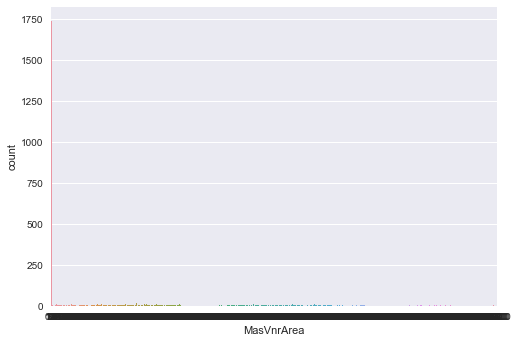

In [99]:
sns.countplot(data['MasVnrArea']);
#check what is the most frequent value
data['MasVnrArea'].value_counts()
#Fillin with the 0 with the all missing value 
data['MasVnrArea'].fillna(0.0,inplace=True)

In [ ]:
#BsmtFinSF1 

In [105]:
data['BsmtFinSF1'].value_counts()
data['BsmtFinSF1'].fillna(929,inplace=True)

In [106]:
#BsmtFinSF2

In [107]:
data['BsmtFinSF2'].value_counts()
data['BsmtFinSF2'].fillna(929,inplace=True)

In [ ]:
#BsmtFullBath

In [109]:
data['BsmtFullBath'].value_counts()

0.0    1705
1.0    1172
2.0      38
3.0       2
Name: BsmtFullBath, dtype: int64

In [112]:
num_data.corr()['BsmtFullBath'].sort_values(ascending=False)[0:6]

BsmtFullBath    1.000000
BsmtFinSF1      0.638847
TotalBsmtSF     0.325623
1stFlrSF        0.261816
SalePrice       0.227122
YearBuilt       0.211580
Name: BsmtFullBath, dtype: float64

In [113]:
data['BsmtFullBath']=data.groupby(['BsmtFinSF1'])['BsmtFullBath'].transform(lambda x:x.fillna(x.mean()))

In [ ]:
#BsmtHalfBath

In [116]:
data['BsmtHalfBath'].value_counts()

0.0    2742
1.0     171
2.0       4
Name: BsmtHalfBath, dtype: int64

In [118]:
data['BsmtHalfBath'].fillna(0.0,inplace=True)

In [124]:
#BsmtUnfSF

In [125]:
data[data['BsmtUnfSF'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,seperate
660,896,0,0,NaN,2,1Fam,NaN,NaN,929.0,929.0,...,0,Pave,4,814.833333,AllPub,0,1946,1950,2008,1


In [126]:
data.loc[data['BsmtUnfSF'].isnull(),'BsmtUnfSF']=0

In [127]:
data.select_dtypes(exclude=['object']).isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
BedroomAbvGr        0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtFullBath        0
BsmtHalfBath        0
BsmtUnfSF           0
EnclosedPorch       0
Fireplaces          0
FullBath            0
GarageArea          0
GarageCars          0
GarageYrBlt         0
GrLivArea           0
HalfBath            0
Id                  0
KitchenAbvGr        0
LotArea             0
LotFrontage         0
LowQualFinSF        0
MSSubClass          0
MasVnrArea          0
MiscVal             0
MoSold              0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PoolArea            0
SalePrice        1459
ScreenPorch         0
TotRmsAbvGrd        0
TotalBsmtSF         0
WoodDeckSF          0
YearBuilt           0
YearRemodAdd        0
YrSold              0
seperate            0
dtype: int64

# categorical data

In [128]:
cate_data=data.select_dtypes(include=['object'])

In [130]:
data.select_dtypes(include=['object']).isnull().sum()

Alley            2721
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
BsmtQual           81
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Foundation          0
Functional          2
GarageCond        159
GarageFinish      159
GarageQual        159
GarageType        157
Heating             0
HeatingQC           0
HouseStyle          0
KitchenQual         1
LandContour         0
LandSlope           0
LotConfig           0
LotShape            0
MSZoning            4
MasVnrType         24
MiscFeature      2814
Neighborhood        0
PavedDrive          0
PoolQC           2909
RoofMatl            0
RoofStyle           0
SaleCondition       0
SaleType            1
Street              0
Utilities           2
dtype: int64

In [131]:
#Alley

In [136]:
data['6'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [139]:
data[data['Alley'].isnull()]['Alley'].head(2)

0    NaN
1    NaN
Name: Alley, dtype: object

In [142]:
# 93,2% of the missing value in Alley is actually NA: No Alley Access
data[data['Alley'].isnull()].shape[0]/data['Alley'].shape[0]
#replace those missing value in Alley into the NA
data['Alley'].fillna('NA',inplace=True)

In [ ]:
#BsmtCond

In [144]:
data['BsmtCond'].value_counts()

TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

In [ ]:
data['BsmtCond'].fillna('NA',inplace=True)

In [ ]:
#BsmtExposure

In [145]:
data['BsmtExposure'].value_counts()

No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64

In [146]:
data['BsmtExposure'].fillna('NA',inplace=True)

In [ ]:
#BsmtFinType1

In [147]:
data['BsmtFinType1'].fillna('NA',inplace=True)

In [ ]:
#BsmtFinType2

In [148]:
data['BsmtFinType2'].fillna('NA',inplace=True)

In [ ]:
#BsmtQual

In [150]:
data['BsmtQual'].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [151]:
data['BsmtQual'].fillna('NA',inplace=True)